#TODO : Out notes and thoughts

Based on the csv file, i want to do some simple analysis

1. Is the Age and the BMI of the patient related to the severity of the lesion?
The first data we're looking at is age, bmi, nihs score (which is the severity of the stroke 0-42), 
and the gs_rankin_6isdeath (which is the severity of the lesion 3 months after the stroke 1-6).

2. [TO-DO] What's the most common location of the lesion?
Look at those locations, and find out which of them had bigger problems, so that 
we can predict the severity of the lesion based on the location of the lesion.

# 🧠 Data Science Project: Ischemic Stroke Outcome Prediction

## Table of Contents

1. [Introduction](#introduction)
2. [Library Imports](#library-imports)
3. [Dataset Description](#dataset-description)
4. [Load the Data](#load-the-data)
5. [Data Cleaning & Preprocessing](#data-cleaning--preprocessing)
    - Handling missing values
    - Filtering stroke patients
6. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
    - 6.1 [Clinical Features (All Patients)](#clinical-features-all)
        - Barplots
        - Histograms
        - Correlation matrix
    - 6.2 [Volumetric Features (All Patients)](#volumetric-features-all)
        - Histograms
        - Scatterplots
        - Correlation matrix
    - 6.3 [Clinical Features (Stroke Patients)](#clinical-features-stroke)
        - Barplots
        - Histograms
        - Correlation matrix
    - 6.4 [Volumetric Features (Stroke Patients)](#volumetric-features-stroke)
        - Histograms
        - Scatterplots
        - Correlation matrix
7. [Feature Selection](#feature-selection)
    - Applying MRMR (Maximum Relevance Minimum Redundancy)
    - Selected features summary
8. [Preparing Data for Machine Learning](#preparing-data-for-machine-learning)
    - Encoding target
    - Train-test split
    - Normalization (if needed)
9. [Model Training & Evaluation](#model-training--evaluation)
    - Logictic Regression
    - Random Forest
    - SVM
    - KNN(Optional)
    - XGBoost(Optional)
    - DecisionTree(Optional)
    - NeuralNetwork TabPFN (Optional)
10. [Results & Discussion](#results-&-discussion)

====================================================

## 1. Introduction     

====================================================


### Feature Descriptions for Stroke Outcome Dataset

This table describes all the columns in the dataset used for ischemic stroke outcome prediction. It includes clinical, anatomical, and volumetric lesion information. Data has been normalized (mean = 0, std = 1).

| **Column Name** | **Description** |
|-----------------|-----------------|
| `ID` | Patient identifier |
| `Total volume (direct)` | Total volume of ischemic lesion in mm³ (normalized) |
| `Number of lesions` | Count of separate ischemic lesions in the brain |
| `Main Side` | Dominant side of lesion location (left/right) |
| `ACAright`, `MCAright`, `PCAright`, `Pons/Medullaright`, `Cerebellumright`, `ACAleft`, `MCAleft`, `PCAleft`, `Pons/Medullaleft`, `Cerebellumleft` | Lesion volume in respective vascular territories |
| `Billateral` | Indicates if lesion affects both brain hemispheres |
| `Totalleft`, `Totalright` | Total lesion volume on left/right hemispheres |
| `Portion largest lesion` | Proportion of the largest lesion to total volume |
| `MNI Volume` | Lesion volume in MNI (standardized brain atlas) space |
| `X (lesions)` | Lesion volume in territory X (e.g., `ACAright (lesions)`) |
| `X (count)` | Number of lesions in territory X (e.g., `MCAleft (count)`) |
| `Total_right (lesion)`, `Total_left (lesion)` | Total lesion volume per side |
| `ratio_sides` | Ratio of right-to-left lesion volume |
| `Billateral (lesions)` | Volume of lesions affecting both hemispheres |
| `Total_anterior (lesion)` | Lesion volume in anterior circulation (ACA & MCA) |
| `Total_posterior (lesion)` | Lesion volume in posterior circulation (PCA, brainstem, cerebellum) |
| `ratio_ant_post` | Ratio of anterior to posterior lesion volumes |
| `ant_and_post_lesions` | Indicator if lesions are present in both anterior and posterior regions |
| `Portion X` | Proportion of lesion volume in vascular territory X (e.g. `Portion MCAleft`) |
| `sex` | Patient's biological sex |
| `age` | Patient's age |
| `acuteischaemicstroke` | 1 = patient had an acute ischemic stroke; 0 = no stroke |
| `priorstroke` | History of previous stroke |
| `bmi` | Body Mass Index |
| `nihss` | NIH Stroke Scale (0 = no deficit, 42 = severe stroke) |
| `gs_rankin_6isdeath` | Modified Rankin Score (0 = no symptoms, 6 = death) |
| `etiology` | Stroke etiology (cause), categorical (1–5) |
| `3rd-ventricle`, `4th-ventricle` | Volumes of brain ventricles |
| `brainstem`, `extracerebral_CSF` | Volumes of anatomical structures |
| `WMH` | White Matter Hyperintensities – important predictor of outcome |
| `summ-white-matter`, `summ-cortex`, `summ-lateral-ventricle`, `summ-cerebellum-white-matter`, `summ-cerebellum-cortex`, `summ-thalamus`, `summ-caudate`, `summ-putamen`, `summ-pallidum`, `summ-hippocampus`, `summ-amygdala`, `summ-accumbens`, `summ-ventral-DC` | Summed volumes of bilateral anatomical brain regions |

---

**Note:**  
- Lesion volumes are extracted from manually segmented MRI data.
- All features are standardized.
- Outcome variable = `gs_rankin_6isdeath` (can be binarized into good [0–2] vs bad [3–6] outcomes). 


====================================================
1. Import Libraries and Configure Settings      

====================================================

In [5]:
# Imports
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%pip install numpy
%pip install seaborn
#!pip install --upgrade --force-reinstall scikit-learn

# Core Libraries
import os
print(os.getcwd())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams

# Set a global plot size
rcParams['figure.figsize'] = 10, 8

# Scikit-learn: Preprocessing, Models, Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score


You should consider upgrading via the '/home/golu/spaces/work/Introduction_Data_Science/data_science/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/golu/spaces/work/Introduction_Data_Science/data_science/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
/home/golu/spaces/work/Introduction_Data_Science


====================================================    

2. Load the Data  

====================================================

In [10]:
# Replace 'stroke_data.csv' with the actual CSV filename if it differs.
data = pd.read_csv("DataScience/data/processed/complete_per_patient_t1_volumetry.csv")

# Preview the data and list all column names
print("Data Preview:")
print(data.head())
print("\nAll Columns in the Dataset:")
print(data.columns.tolist())
print(len(data))

Data Preview:
      ID  Total volume (direct)  Number of lesions  Main Side  ACAright  \
0  sub-2               0.880707           0.132130          1    10.424   
1  sub-3               2.184380           0.017070          0     0.400   
2  sub-5              -0.571408          -0.558231          1     0.035   
3  sub-8               0.824821           0.477311          1    55.660   
4  sub-9               0.021404          -0.443171          0     0.000   

   MCAright  PCAright  Pons/Medullaright  Cerebellumright  ACAleft  ...  \
0    75.990    21.287                0.0            0.000    3.280  ...   
1     0.557     0.000                0.0            7.167   24.304  ...   
2     1.120     0.000                0.0            0.000    0.000  ...   
3    32.249     0.319                0.0            0.000    8.454  ...   
4     0.000     0.000                0.0            0.000    2.533  ...   

   summ-cerebellum-white-matter  summ-cerebellum-cortex  summ-thalamus  \
0         

====================================================    

3. Data Cleaning & Filtering    

====================================================

In [ ]:
# 3.1 Remove duplicate rows, if any
initial_shape = data.shape
data.drop_duplicates(inplace=True)
print(f"\nRemoved {initial_shape[0] - data.shape[0]} duplicate rows.")

# Columns of interest for cleaning/analysis
cols_of_interest = ['sex', 'age', 'bmi', 'nihss', 'gs_rankin_6isdeath', 'acuteischaemicstroke']

# 3.2 Drop rows with missing values in columns of interest (example approach)
before_dropna_shape = data.shape
data.dropna(subset=cols_of_interest, inplace=True)
print(f"Removed {before_dropna_shape[0] - data.shape[0]} rows due to missing values in columns of interest.")

# 3.3 Convert or unify 'sex' values if needed
# Example: If 'sex' is coded as 1=male, 2=female, or M/F strings
sex_mapping = {
    1: 'male',
    2: 'female',
    'M': 'male',
    'F': 'female'
}
data['sex'] = data['sex'].replace(sex_mapping)

# 3.4 Filter outliers or invalid ranges (adjust thresholds as appropriate)
valid_age_mask = (data['age'] >= 0) & (data['age'] <= 120)
valid_bmi_mask = (data['bmi'] >= 10) & (data['bmi'] <= 50)
valid_nihss_mask = (data['nihss'] >= 0) & (data['nihss'] <= 42)
valid_rankin_mask = (data['gs_rankin_6isdeath'] >= 1) & (data['gs_rankin_6isdeath'] <= 6)

combined_mask = valid_age_mask & valid_bmi_mask & valid_nihss_mask & valid_rankin_mask
before_filter_shape = data.shape
data = data[combined_mask]
print(f"Removed {before_filter_shape[0] - data.shape[0]} rows due to out-of-range values.")

# Create a final cleaned subset with the columns of interest
# (Include 'acuteischaemicstroke' so we can visualize stroke counts)
clean_cols = ['sex', 'age', 'bmi', 'nihss', 'gs_rankin_6isdeath', 'acuteischaemicstroke']
data_subset = data[clean_cols]

print("\nCleaned Data Subset Preview:")
print(data_subset.head())
print("\nSummary of Cleaned Data Subset:")
print(data_subset.describe())



Removed 0 duplicate rows.
Removed 0 rows due to missing values in columns of interest.
Removed 0 rows due to out-of-range values.

Cleaned Data Subset Preview:
     sex  age    bmi  nihss  gs_rankin_6isdeath  acuteischaemicstroke
1      0   87  19.23   15.0                 6.0                   1.0
4      0   70  26.89   18.0                 4.0                   1.0
7   male   72  30.48    0.0                 2.0                   1.0
12  male   41  23.67   14.0                 2.0                   1.0
15  male   76  30.04    1.0                 1.0                   1.0

Summary of Cleaned Data Subset:
              age         bmi       nihss  gs_rankin_6isdeath  \
count  484.000000  484.000000  484.000000          484.000000   
mean    64.229339   28.138202   10.316116            3.041322   
std     14.495201    6.266422    8.393362            1.575678   
min     19.000000   12.800000    0.000000            1.000000   
25%     55.000000   23.962500    3.000000            2.000000

====================================================    

4. Correlation Analysis (Cleaned Data)  

====================================================

In [1]:
numeric_cols = ['age', 'bmi', 'nihss', 'gs_rankin_6isdeath']
corr_matrix = data_subset[numeric_cols].corr()
print("\nCorrelation Matrix (Cleaned Data):")
print(corr_matrix)

NameError: name 'data_subset' is not defined

====================================================    

5. Original Grid of Plots (Scatter, Box, Heatmap)   

====================================================

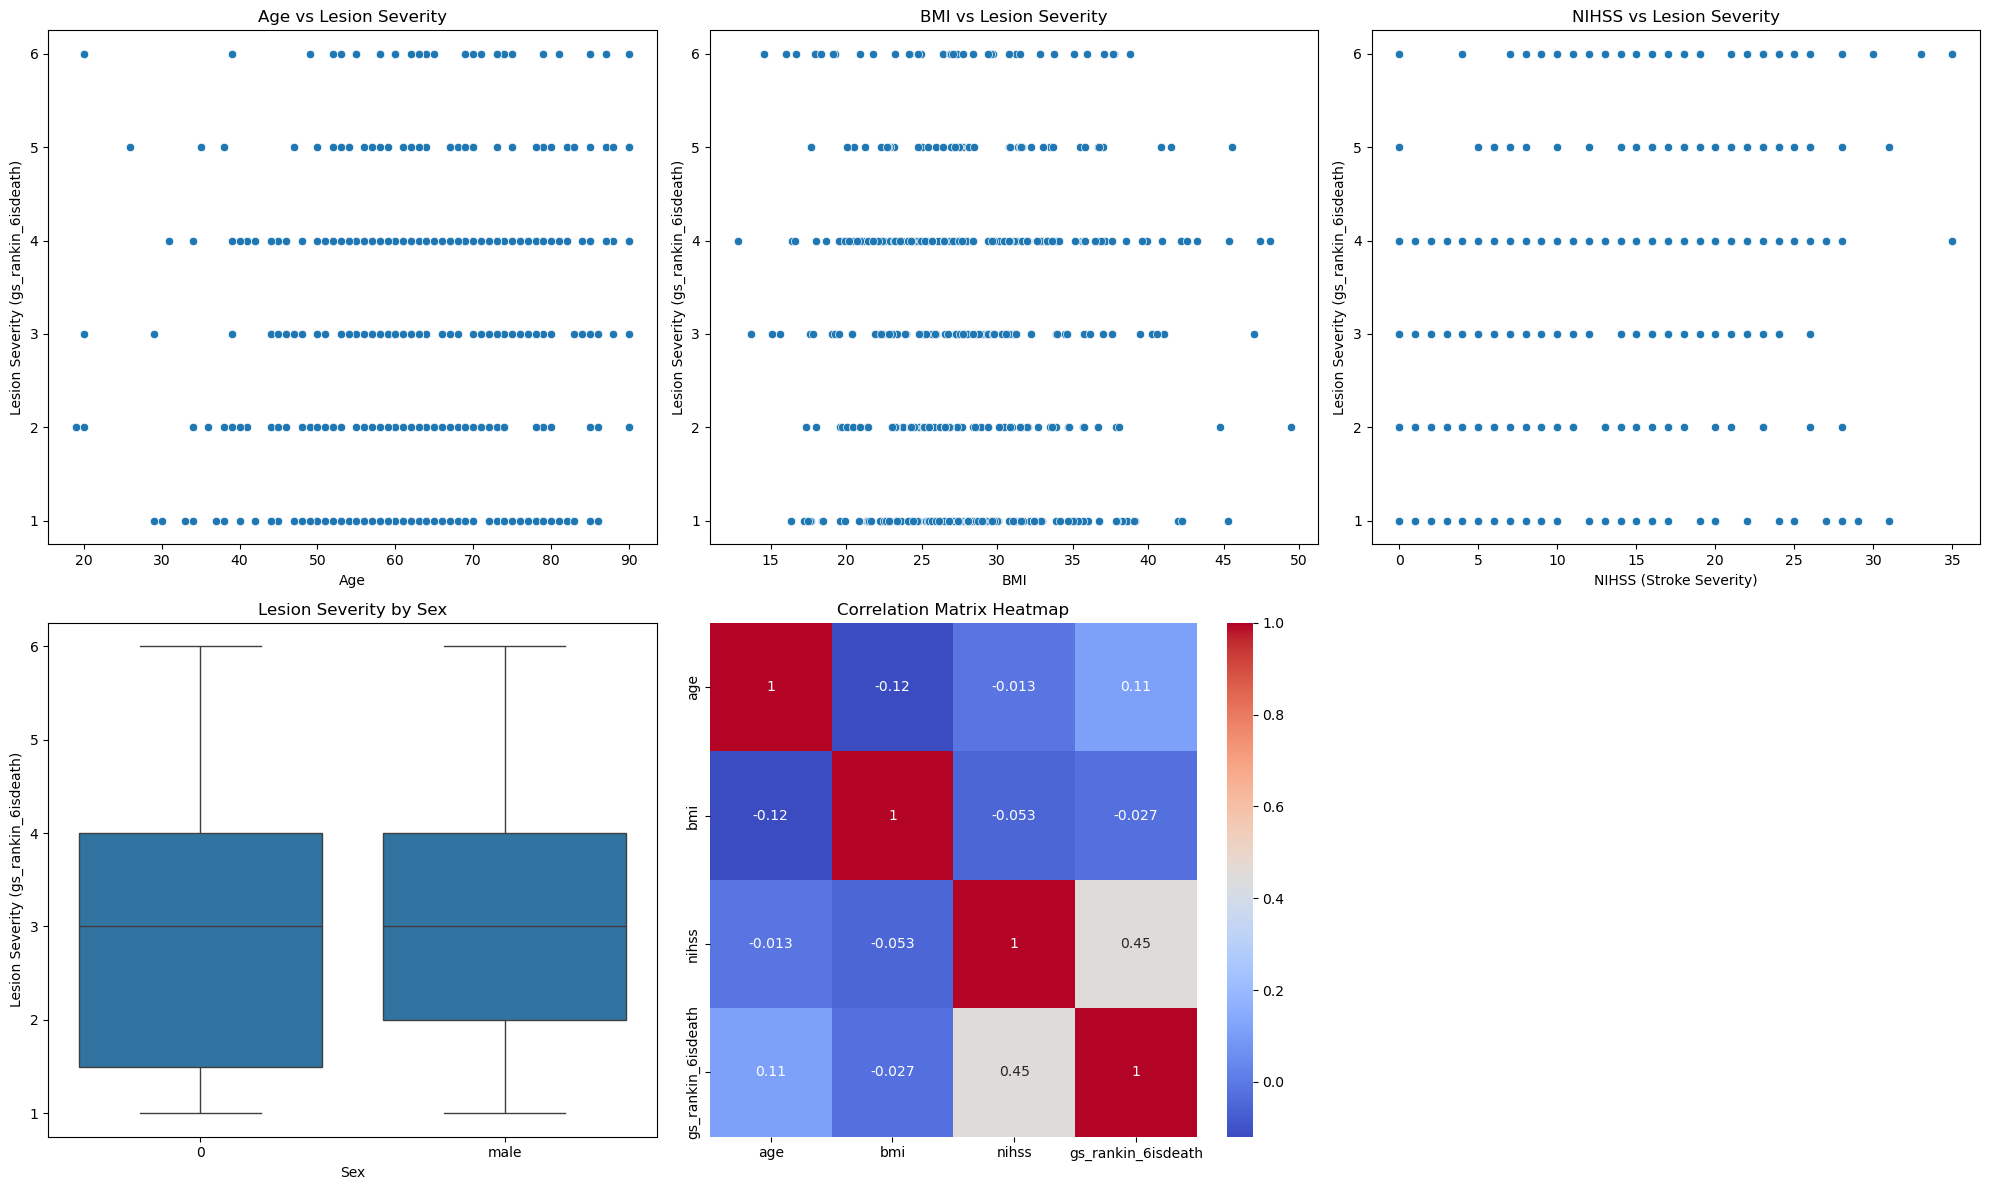

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Age vs Lesion Severity
sns.scatterplot(ax=axs[0, 0], x='age', y='gs_rankin_6isdeath', data=data_subset)
axs[0, 0].set_title('Age vs Lesion Severity')
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('Lesion Severity (gs_rankin_6isdeath)')

# Plot 2: BMI vs Lesion Severity
sns.scatterplot(ax=axs[0, 1], x='bmi', y='gs_rankin_6isdeath', data=data_subset)
axs[0, 1].set_title('BMI vs Lesion Severity')
axs[0, 1].set_xlabel('BMI')
axs[0, 1].set_ylabel('Lesion Severity (gs_rankin_6isdeath)')

# Plot 3: NIHSS vs Lesion Severity
sns.scatterplot(ax=axs[0, 2], x='nihss', y='gs_rankin_6isdeath', data=data_subset)
axs[0, 2].set_title('NIHSS vs Lesion Severity')
axs[0, 2].set_xlabel('NIHSS (Stroke Severity)')
axs[0, 2].set_ylabel('Lesion Severity (gs_rankin_6isdeath)')

# Plot 4: Boxplot - Lesion Severity by Sex
sns.boxplot(ax=axs[1, 0], x='sex', y='gs_rankin_6isdeath', data=data_subset)
axs[1, 0].set_title('Lesion Severity by Sex')
axs[1, 0].set_xlabel('Sex')
axs[1, 0].set_ylabel('Lesion Severity (gs_rankin_6isdeath)')

# Plot 5: Heatmap - Correlation Matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axs[1, 1])
axs[1, 1].set_title('Correlation Matrix Heatmap')

# Leave the 6th subplot empty or for future use
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

====================================================    

6. Additional Plots: Stroke Patients' Age & BMI Distributions   

====================================================

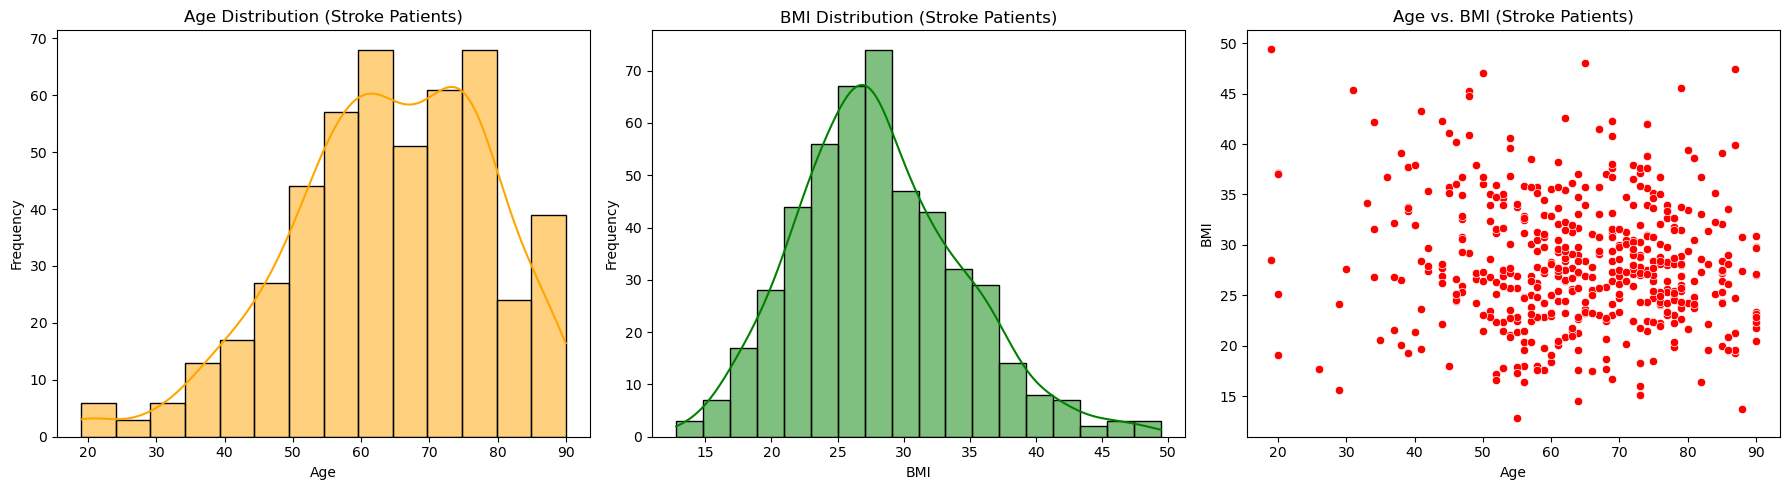

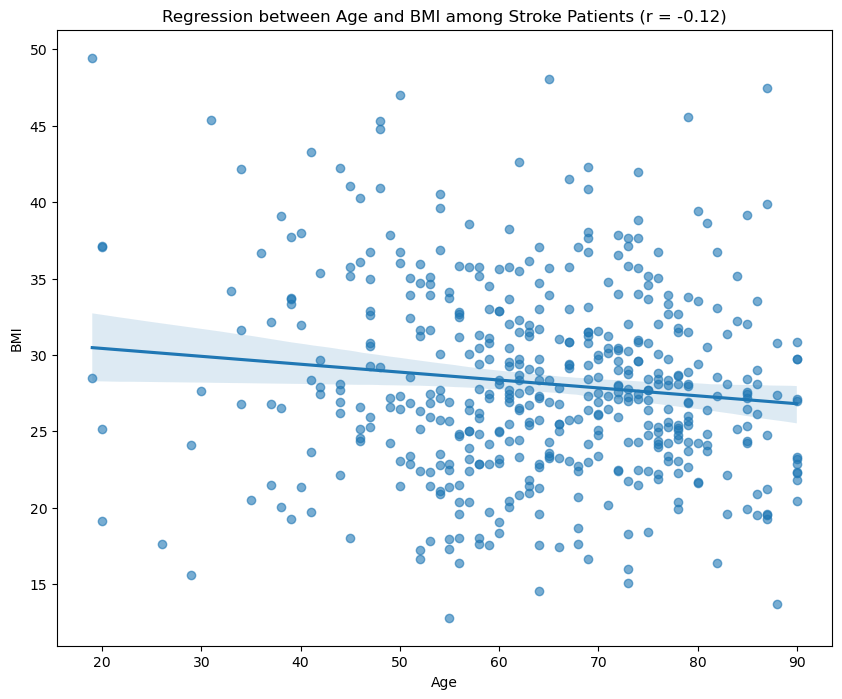

In [ ]:
# Filter data for stroke patients only
stroke_data = data[data['acuteischaemicstroke'] == 1]

# Arrange the three plots in a 1x3 grid.
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5))

# 6.1 Age Distribution for Stroke Patients
sns.histplot(stroke_data['age'], kde=True, ax=axs2[0], color='orange')
axs2[0].set_title("Age Distribution (Stroke Patients)")
axs2[0].set_xlabel("Age")
axs2[0].set_ylabel("Frequency")

# 6.2 BMI Distribution for Stroke Patients
sns.histplot(stroke_data['bmi'], kde=True, ax=axs2[1], color='green')
axs2[1].set_title("BMI Distribution (Stroke Patients)")
axs2[1].set_xlabel("BMI")
axs2[1].set_ylabel("Frequency")

# 6.3 Combined Scatter: Age vs. BMI (Stroke Patients)
sns.scatterplot(x='age', y='bmi', data=stroke_data, ax=axs2[2], color='red')
axs2[2].set_title("Age vs. BMI (Stroke Patients)")
axs2[2].set_xlabel("Age")
axs2[2].set_ylabel("BMI")

plt.tight_layout()
plt.show()

# ====================================================
# 7. Mixed Analysis: Regression between Age and BMI among Stroke Patients
# ====================================================
# Compute the Pearson correlation coefficient between Age and BMI.
corr_val = stroke_data['age'].corr(stroke_data['bmi'])

# Create a plot with a regression line.
plt.figure(figsize=(10, 8))
sns.regplot(data=stroke_data, x='age', y='bmi', scatter_kws={'alpha': 0.6})
plt.title(f"Regression between Age and BMI among Stroke Patients (r = {corr_val:.2f})")
plt.xlabel("Age")
plt.ylabel("BMI")
plt.show()

(0.0, 6.0)

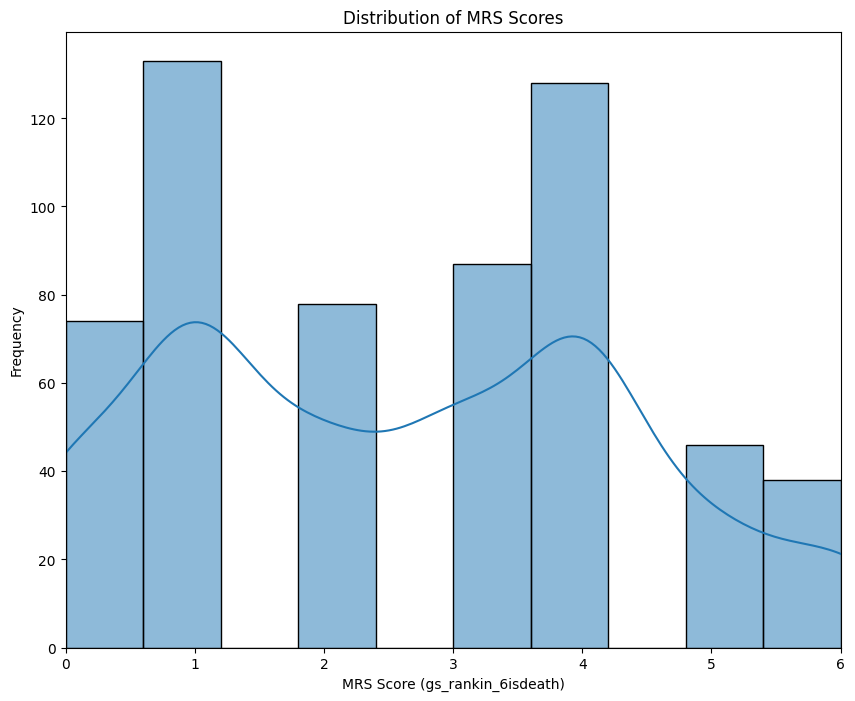

In [ ]:
# Histogram of MRS scores

plt.figure()
sns.histplot(data['gs_rankin_6isdeath'], bins=10, kde=True)
plt.title('Distribution of MRS Scores')
plt.xlabel('MRS Score (gs_rankin_6isdeath)')
plt.ylabel('Frequency')
plt.xlim(0, 6)

In [ ]:
# Binarized MRS scores

import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data['rankin_binary'], bins=2, discrete=True)

plt.xticks([0, 1])  # Set x-axis ticks to only 0 and 1
plt.xlabel('Binary MRS Score (0=Good, 1=Poor)')
plt.ylabel('Frequency')
plt.title('Distribution of Binary MRS Scores')
plt.show()




NameError: name 'data' is not defined